### Volkswagen Data Time Series Analysis

In [1]:
# importing packages

import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace import sarimax
from pmdarima.arima import auto_arima
from pmdarima.arima import OCSBTest
from arch import arch_model
import seaborn as sns
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

In [2]:
# importing data

raw_data = yfinance.download(tickers= "VOW3.DE, PAH3.DE, BMW.DE", interval='1d',group_by='ticker',
                             auto_adjust= True, threads=True)

[*********************100%***********************]  3 of 3 completed


In [3]:
df = raw_data.copy()
df.tail()

Ticker        PAH3.DE                                                BMW.DE  \
Price            Open       High        Low      Close    Volume       Open   
Date                                                                          
2025-05-14  38.090000  38.090000  38.090000  38.090000       0.0  79.680008   
2025-05-15  38.029999  38.419998  37.840000  37.980000  656601.0  78.099998   
2025-05-16  37.980000  37.980000  37.980000  37.980000       0.0  77.680000   
2025-05-19  37.990002  38.299999  37.040001  37.290001  787877.0  76.699997   
2025-05-20  37.200001  37.959999  37.060001  37.919998  375416.0  77.540001   

Ticker                                                   VOW3.DE              \
Price            High        Low      Close   Volume        Open        High   
Date                                                                           
2025-05-14  79.680008  79.680008  79.680008        0  104.949997  104.949997   
2025-05-15  78.919998  77.160004  77.580002  1229215  103.150002  104.099998   
2025-05-16  78.180000  76.660004  76.919998  1029744  104.000000  104.599998   
2025-05-19  77.720001  76.699997  77.559998   579046   97.000000   98.620003   
2025-05-20  79.519997  76.519997  79.160004  1093544   97.699997   98.699997   

Ticker                                         
Price              Low       Close     Volume  
Date                                           
2025-05-14  104.949997  104.949997        0.0  
2025-05-15  102.900002  103.800003   798333.0  
2025-05-16  102.150002  102.849998  1518948.0  
2025-05-19   96.800003   97.500000  1444026.0  
2025-05-20   96.839996   98.239998   531155.0

In [4]:
# Defining Key Dates

# starting date
start_date = '2009-04-05'

# first official announcement 49.9%
ann_1 = '2009-12-09'

# second official announcement 50.1
ann_2 = '2012-07-05'

#ending date
end_date = '2014-01-01'

# dieselgate
d_gate = '2015-09-20'

#### Data Preprocessing

In [5]:
# extracting closing prices

df['vol'] = df['VOW3.DE'].Close
df['por'] = df['PAH3.DE'].Close
df['bmw'] = df['BMW.DE'].Close

# creating returns

df['ret_vol'] = df['vol'].pct_change(1).mul(100)
df['ret_por'] = df['por'].pct_change(1).mul(100)
df['ret_bmw'] = df['bmw'].pct_change(1).mul(100)

# creating squared returns

df['sq_vol'] = df.ret_vol.mul(df.ret_vol)
df['sq_por'] = df.ret_por.mul(df.ret_por)
df['sq_bmw'] = df.ret_bmw.mul(df.ret_bmw)

# extracting volume

df['q_vol'] = df['VOW3.DE'].Volume
df['q_por'] = df['PAH3.DE'].Volume
df['q_bmw'] = df['BMW.DE'].Volume

In [6]:
# assigning frequency and the fill missing data

df = df.asfreq('b')
df = df.fillna(method='ffill')

In [7]:
# removing surplus data

del df['VOW3.DE']
del df['PAH3.DE']
del df['BMW.DE']

df.tail()

Ticker,vol,por,bmw,ret_vol,ret_por,ret_bmw,sq_vol,sq_por,sq_bmw,q_vol,q_por,q_bmw
Price,,,,,,,,,,,,
Date,,,,,,,,,,,,
2025-05-14,104.949997,38.090000,79.680008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2025-05-15,103.800003,37.980000,77.580002,-1.095754,-0.288791,-2.635550,1.200677,0.083400,6.946122,798333.0,656601.0,1229215.0
2025-05-16,102.849998,37.980000,76.919998,-0.915226,0.000000,-0.850739,0.837639,0.000000,0.723758,1518948.0,0.0,1029744.0
2025-05-19,97.500000,37.290001,77.559998,-5.201749,-1.816742,0.832033,27.058190,3.300552,0.692278,1444026.0,787877.0,579046.0
2025-05-20,98.239998,37.919998,79.160004,0.758972,1.689454,2.062927,0.576039,2.854253,4.255668,531155.0,375416.0,1093544.0


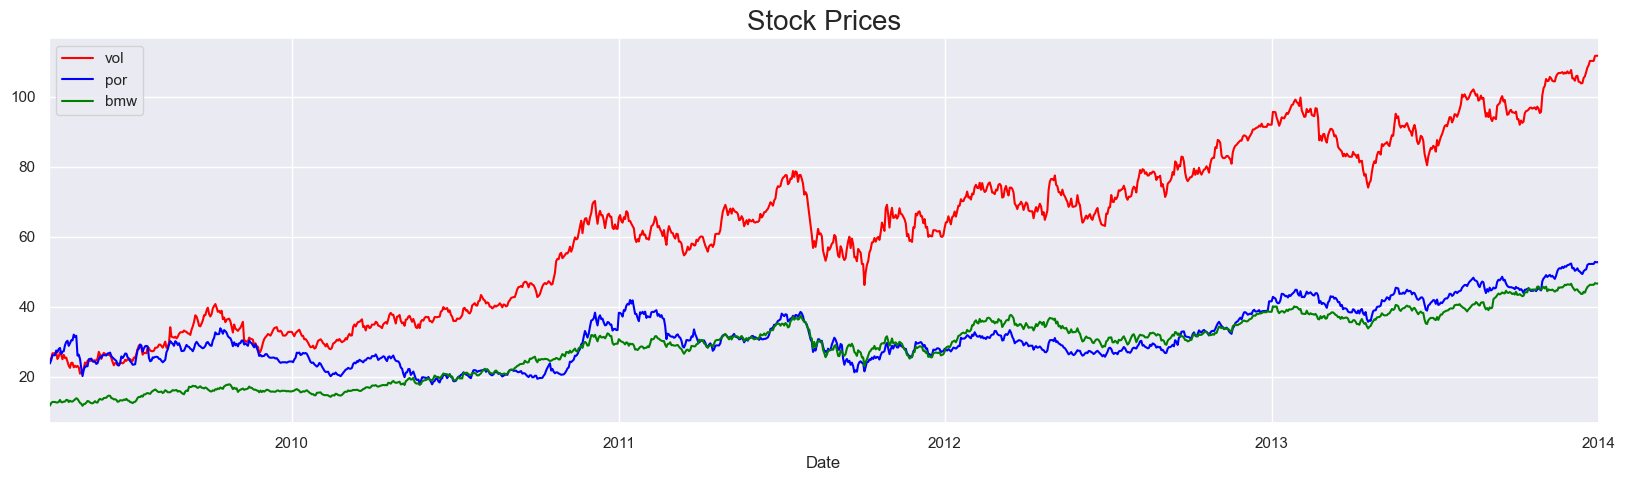

In [8]:
# plotting stock price data

df['vol'][start_date:end_date].plot(figsize=(20,5),color = 'red')
df['por'][start_date:end_date].plot(color = 'blue')
df['bmw'][start_date:end_date].plot(color = 'green')
plt.title('Stock Prices', size=20)
plt.legend()
plt.show()

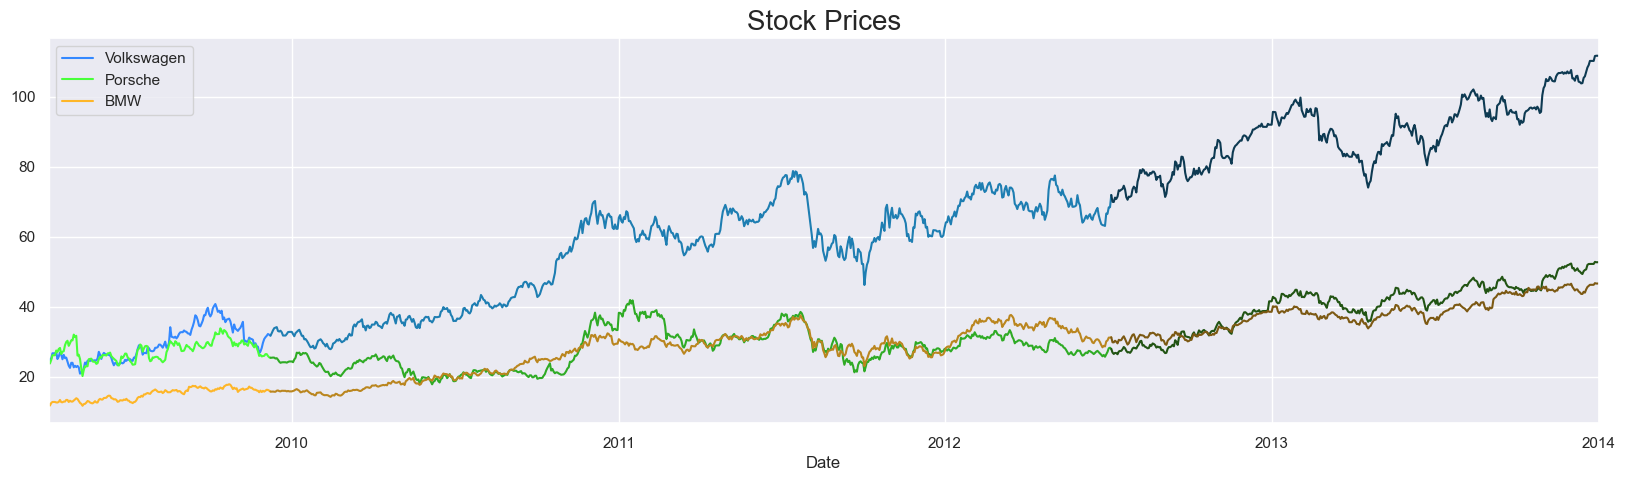

In [9]:
# plotting different intervals with different shades of colours to have a better idea

df['vol'][start_date:ann_1].plot(figsize=(20,5),color = '#3388FF')
df['por'][start_date:ann_1].plot(color = '#49FF3A')
df['bmw'][start_date:ann_1].plot(color = '#FEB628')

df['vol'][ann_1:ann_2].plot(color = '#1E7EB2')
df['por'][ann_1:ann_2].plot(color = '#2FAB25')
df['bmw'][ann_1:ann_2].plot(color = '#BA861F')

df['vol'][ann_2:end_date].plot(color = '#0E3A52')
df['por'][ann_2:end_date].plot(color = '#225414')
df['bmw'][ann_2:end_date].plot(color = '#7C5913')

plt.title('Stock Prices', size=20)
plt.legend(['Volkswagen','Porsche','BMW'])
plt.show()

#### Correlation

In [10]:
print ('Correlation among manufacturers from ' + str(start_date) + ' to ' + str(end_date) +'\n')
print('Volkswagen and Porsche Correlation: \t' + str(df['vol'][start_date:end_date].corr(df['por'][start_date:end_date])))
print('Volkswagen and BMW Correlation: \t' + str(df['vol'][start_date:end_date].corr(df['bmw'][start_date:end_date])))
print('Porsche and BMW Correlation: \t' + str(df['por'][start_date:end_date].corr(df['bmw'][start_date:end_date])))

Correlation among manufacturers from 2009-04-05 to 2014-01-01

Volkswagen and Porsche Correlation: 	0.8364635007007325
Volkswagen and BMW Correlation: 	0.9798969114999413
Porsche and BMW Correlation: 	0.805725429183186


In [11]:
print ('Correlation among manufacturers from ' + str(start_date) + ' to ' + str(ann_1) +'\n')
print('Volkswagen and Porsche Correlation: \t' + str(df['vol'][start_date:ann_1].corr(df['por'][start_date:ann_1])))
print('Volkswagen and BMW Correlation: \t' + str(df['vol'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))
print('Porsche and BMW Correlation: \t' + str(df['por'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))

Correlation among manufacturers from 2009-04-05 to 2009-12-09

Volkswagen and Porsche Correlation: 	0.6762282404249383
Volkswagen and BMW Correlation: 	0.844170435104143
Porsche and BMW Correlation: 	0.6217078002931062


This suggests that the stock prices for these brands weren't too similar before the start of the buyout.

In [12]:
print ('Correlation among manufacturers from ' + str(ann_1) + ' to ' + str(ann_2) +'\n')
print('Volkswagen and Porsche Correlation: \t' + str(df['vol'][ann_1:ann_2].corr(df['por'][ann_1:ann_2])))
print('Volkswagen and BMW Correlation: \t' + str(df['vol'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))
print('Porsche and BMW Correlation: \t' + str(df['por'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))

Correlation among manufacturers from 2009-12-09 to 2012-07-05

Volkswagen and Porsche Correlation: 	0.7434172790564182
Volkswagen and BMW Correlation: 	0.979587800809053
Porsche and BMW Correlation: 	0.7051170810150201


In [13]:
print ('Correlation among manufacturers from ' + str(ann_2) + ' to ' + str(end_date) +'\n')
print('Volkswagen and Porsche Correlation: \t' + str(df['vol'][ann_2:end_date].corr(df['por'][ann_2:end_date])))
print('Volkswagen and BMW Correlation: \t' + str(df['vol'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))
print('Porsche and BMW Correlation: \t' + str(df['por'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))

Correlation among manufacturers from 2012-07-05 to 2014-01-01

Volkswagen and Porsche Correlation: 	0.9409608763043651
Volkswagen and BMW Correlation: 	0.9291131225756777


Porsche and BMW Correlation: 	0.9497199902592344


In [14]:
print ('Correlation among manufacturers from ' + str(end_date) + ' to ' + str(df.index[-1]) +'\n')
print('Volkswagen and Porsche Correlation: \t' + str(df['vol'][end_date:].corr(df['por'][end_date:])))
print('Volkswagen and BMW Correlation: \t' + str(df['vol'][end_date:].corr(df['bmw'][end_date:])))
print('Porsche and BMW Correlation: \t' + str(df['por'][end_date:].corr(df['bmw'][end_date:])))

Correlation among manufacturers from 2014-01-01 to 2025-05-20 00:00:00

Volkswagen and Porsche Correlation: 	0.8368523248727839
Volkswagen and BMW Correlation: 	0.4822742932312125
Porsche and BMW Correlation: 	0.2084752067619077


#### Best Fitting Models

##### For Volkswagen

In [15]:
mod_pr_pre_vol = auto_arima(df.vol[start_date:ann_1],exogenous = df[['por','bmw']][start_date:ann_1],
                            m=5,max_p=5,max_q=5)
mod_pr_btn_vol = auto_arima(df.vol[ann_1:ann_2],exogenous = df[['por','bmw']][ann_1:ann_2],
                            m=5,max_p=5,max_q=5)
mod_pr_post_vol = auto_arima(df.vol[ann_2:end_date],exogenous = df[['por','bmw']][ann_2:end_date],
                            m=5,max_p=5,max_q=5)

In [16]:
mod_pr_pre_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -258.661
Date:                Tue, 20 May 2025   AIC                            519.322
Time:                        21:06:01   BIC                            522.498
Sample:                    04-06-2009   HQIC                           520.610
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.0885      0.061     17.983      0.000       0.970       1.207
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):               232.52
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               2.10   Skew:                            -0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
mod_pr_btn_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1168.284
Date:                Tue, 20 May 2025   AIC                           2338.567
Time:                        21:06:18   BIC                           2343.076
Sample:                    12-09-2009   HQIC                          2340.314
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.9047      0.076     25.213      0.000       1.757       2.053
===================================================================================
Ljung-Box (L1) (Q):                   1.99   Jarque-Bera (JB):                90.13
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               5.51   Skew:                             0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
mod_pr_post_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  390
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -659.346
Date:                Tue, 20 May 2025   AIC                           1322.691
Time:                        21:06:35   BIC                           1330.618
Sample:                    07-05-2012   HQIC                          1325.834
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0783      0.047      1.662      0.097      -0.014       0.171
sigma2         1.7368      0.090     19.262      0.000       1.560       1.914
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                65.38
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                            -0.16
Prob(H) (two-sided):                  0.51   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### For Porsche

In [23]:
mod_pr_pre_por = auto_arima(df.por[start_date:ann_1],exogenous = df[['vol','bmw']][start_date:ann_1],
                            m=5,max_p=5,max_q=5)
mod_pr_btn_por = auto_arima(df.por[ann_1:ann_2],exogenous = df[['vol','bmw']][ann_1:ann_2],
                            m=5,max_p=5,max_q=5)
mod_pr_post_por = auto_arima(df.por[ann_2:end_date],exogenous = df[['vol','bmw']][ann_2:end_date],
                            m=5,max_p=5,max_q=5)

In [24]:
mod_pr_pre_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -245.755
Date:                Tue, 20 May 2025   AIC                            493.510
Time:                        21:14:23   BIC                            496.686
Sample:                    04-06-2009   HQIC                           494.798
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.9408      0.050     19.004      0.000       0.844       1.038
===================================================================================
Ljung-Box (L1) (Q):                   2.17   Jarque-Bera (JB):               319.80
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                            -1.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Not relying on past values or residuals.

In [25]:
mod_pr_btn_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -786.982
Date:                Tue, 20 May 2025   AIC                           1577.964
Time:                        21:14:23   BIC                           1586.982
Sample:                    12-09-2009   HQIC                          1581.457
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0988      0.031      3.147      0.002       0.037       0.160
sigma2         0.6113      0.019     31.673      0.000       0.573       0.649
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               465.32
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               2.16   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Not relying on past values or but rely on residuals.

In [26]:
mod_pr_post_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  390
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -395.072
Date:                Tue, 20 May 2025   AIC                            794.144
Time:                        21:14:23   BIC                            802.071
Sample:                    07-05-2012   HQIC                           797.286
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0637      0.034      1.875      0.061      -0.003       0.130
sigma2         0.4463      0.025     17.715      0.000       0.397       0.496
===================================================================================
Ljung-Box (L1) (Q):                   0.83   Jarque-Bera (JB):                26.23
Prob(Q):                              0.36   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                             0.13
Prob(H) (two-sided):                  0.99   Kurtosis:                         4.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Predictions for the future